In [86]:

import importlib
import modules
from collections import Counter
import numpy as np
import powerlaw
importlib.reload(modules)

from modules import CA
from modules import triangulize_evolution
from modules import find_jams
import matplotlib.pyplot as plt

from modules import run_model_stochastic
import random


importlib.reload(modules)


<module 'modules' from '/Users/carokluin/Documents/CSM/ComplexSystems/Project_complexsystems/CSS-Group1/modules.py'>

# Traffic density heatmap
## We could plot the traffic density over time, see if it approaches the critical density like we would expect for Self-Organized Criticality

In [45]:
def plot_traffic_density(evolution):
    """
    Plot the traffic density heatmap for a given density evolution.

    Parameters:
    - evolution (numpy.ndarray): Traffic density evolution over time and space.
    """
    plt.figure(figsize=(10, 6))
    plt.imshow(evolution, cmap='YlOrRd', aspect='auto', origin='lower')
    plt.colorbar(label='Traffic Density')
    plt.xlabel('Position')
    plt.ylabel('Time Step')
    plt.title('Traffic Density Evolution')

    plt.show()


# Density as function of critical exponent 

In [46]:
#Fit power law curve: density as a function of the critical exponents

# Calculate mean and standard deviation of critical exponents

mean_critical_exponents = np.mean(all_critical_exponents, axis=0)
std_critical_exponents = np.std(all_critical_exponents, axis=0)

# Fit a curve to the mean critical exponents
def func(x, a, b):
    return a * x ** -b 

popt, pcov = curve_fit(func, all_densities[0], mean_critical_exponents, p0=[1, 0.5])

# Plot the results
plt.figure(figsize=(8, 6))

#Plot individual datapoints from iterations
for i in range(n_alpha):
    plt.plot(all_densities[i], all_critical_exponents[i], 'o', color="blue")

#Plot the mean values with std dev
plt.errorbar(all_densities[0], mean_critical_exponents, yerr=std_critical_exponents, fmt='o-', color='black', label='Mean ± StdDev')

#plot the fitted curve
x_fit = np.linspace(min(all_densities[0]), max(all_densities[0]), 100)
y_fit = func(x_fit, *popt)
plt.plot(x_fit, y_fit, '--', color='red', label=f'Fitted Curve: a={popt[0]:.2f}, b={popt[1]:.2f}')

plt.xlabel('Density (p)')
plt.ylabel('Fitted Critical Exponent')
plt.title('Critical Exponent vs. Density for L=500')
plt.legend()
plt.show()

NameError: name 'all_critical_exponents' is not defined

# Functions that checks if powerlaw distribution can be fitted

In [92]:
#set up function to fit power law distribution
def analyze_powerlaw_distribution(data):
    """
    Function that analysis the distribution of given data with the powerlaw package
    (Only designed for heavy tailed distributions!)
    Makes use of the Kolmogorov-Smirnov test for which H0: data is power-law distributed, HA: data is not power-law distributed
    If H0 is rejected, the function will check if the data is exponentially distributed 
    If the function is not exponentially distributed, the function will return:
      "Not a power-law distribution (No alternative distribution fit available"


    Input: data (array-like)
    Output: string with distribution type

    """
    #Make data in array format
    data = np.asarray(data)

    #Fit to a power-law distribution
    fit = powerlaw.Fit(data, discrete=True)

    #Goodness of fit using the Kolmogorov-Smirnov test for power-law vs. exponential
    distr1 = "power_law"
    distr2 = "exponential"
    ks_stat, ks_p_value = fit.distribution_compare(distr1, distr2, normalized_ratio=True)
    exponent = fit.power_law.alpha
    

    # Analyze the fit and return the result
    if ks_stat > 0:
        # R log likelihood was positive, so data prefers power-law distribution
        result = f"Data prefers {distr1} over {distr2} (p-value: {ks_p_value:.4f})"

    else:
        # R log likelihood was negative, so data prefers exponential distribution
        result = f"Data prefers {distr2} over {distr1} (p-value: {ks_p_value:.4f})"

    return result, exponent



# Example of how to use the function analyze_powerlaw_distribution

Calculating best minimal value for power law fit
Power-law distribution


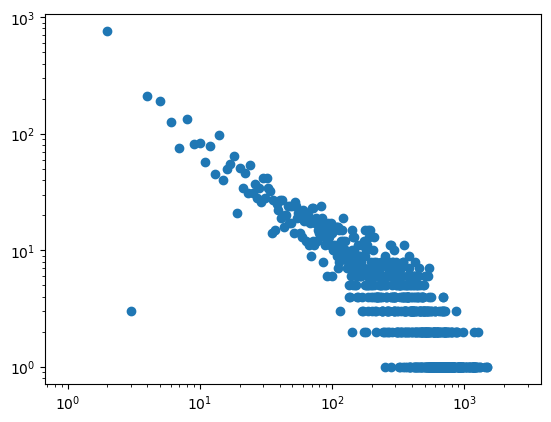

In [ ]:

lifespan_count, jam_count = run_model_stochastic(p, L, T, n_repetitions, v_max, p_slowdown)

result_jam_test = analyze_powerlaw_distribution(list(jam_count.elements()))
print(result_jam_test)

#plt.hist(list(jam_size_counter.elements()), bins=100, density=True, label="Jam size distribution")
plt.loglog(range(1, int(max(jam_count.keys()))), [jam_count[i] for i in range(1, int(max(jam_count.keys())))], 'o')

# Function that not only checks powerlaw 2.0 
## Function that checks powerlaw versus exponential AND checks for bionomial, poisson and gamma 

In [212]:
from scipy.stats import ks_2samp
from scipy.stats import poisson
from scipy.stats import gamma
from scipy.stats import binom

#set up function to fit power law distribution and other distributions
def analyze_powerlaw_distribution2(data):
    """
    Function that analysis the distribution of given data with the powerlaw package
    
    Makes use of the Kolmogorov-Smirnov test for which H0: data is .. distributed, HA: data is not .. distributed
    If H0 is rejected for the power law distribution, the function will check if the data is exponentially,bionomial,gamma or poisson distributed 
    If the function is not matched with any of these distributions, the function will return:
      "No alternative distribution fit available"


    Input: data (array-like)
    Output: string with distribution type

    """
    #Make data in array format
    data = np.asarray(data)

    #Fit to a power-law distribution
    fit = powerlaw.Fit(data, discrete=True, verbose=True)

    #Goodness of fit using the Kolmogorov-Smirnov test for power-law vs. exponential
    ks_stat_powerlaw, ks_p_value_powerlaw = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)

#Check for power law distribution
    if ks_p_value_powerlaw < 0.05:
        result = "Not a power-law distribution"

        #Calculate p-values for alternative distributions
        ks_p_value_exponential = ks_2samp(data, np.random.exponential(np.mean(data), len(data)))[1]
        ks_p_value_poisson = ks_2samp(data, poisson.rvs(np.mean(data), size=len(data)))[1]
        ks_p_value_binomial = ks_2samp(data, np.random.binomial(n=int(np.mean(data)), p=0.5, size=len(data)))[1]
        ks_p_value_gamma = ks_2samp(data, gamma.rvs(np.mean(data)/2, scale=2, size=len(data)))[1]

        #Check alternative distributions, because we did 4 tests, we need to correct for multiple testing with bonferroni (0.05/4)
        if ks_p_value_exponential < 0.05/4:
            result += f" (Exponential fit p-value: {ks_p_value_exponential:.4f})"
        elif ks_p_value_poisson < 0.05/4:
            result += " (Poisson distribution)"
        elif ks_p_value_binomial < 0.05/4:
            result += " (Binomial distribution)"
        elif ks_p_value_gamma < 0.05/4:
            result += " (Gamma distribution)"
        else:
            result += " (No alternative distribution fit available)"

    else:
        result = "Power-law distribution"


In [ ]:

def plot_model_evolution(evolution, v_max, title="NaSch Model Evolution", cmap="Greys"):
    """
    Function to plot the evolution of the NaSch model.

    Parameters:
    - evolution (list): List containing the evolution of the model for each timestep.
    - v_max (int): Maximum speed of vehicles.
    - title (str): Title of the plot.
    - cmap (str): Colormap for the heatmap.

    Returns:
    - None (displays the plot).
    """
    density_evolution = np.array([[np.sum([cell[0] for cell in state]) / len(state) for state in evolution]])

    plt.figure(figsize=(10, 6))
    plt.imshow(density_evolution, cmap=cmap, origin="lower", aspect="auto", extent=[0, len(evolution[0]), 0, len(evolution)])
    plt.title(title)
    plt.xlabel("Time Step")
    plt.ylabel("Cell Index")
    plt.colorbar(label="Density")
    plt.yticks(np.arange(0, len(evolution) + 1, 5))
    plt.xticks(np.arange(0, len(evolution[0]) + 1, 5))
    plt.show()



# Code to capture the density over time 

In [9]:
def density_evolution_nasch (evolution):
    """
    Function to calculate the density evolution of the NaSch model. The density is defined as the
    amount of cars in total. This is calculated by summing the total amount of cars.
    Input: 
    - evolution (list): List containing the evolution of the model for each timestep.
    Output:
    - density_evolution (list): List containing the density evolution of the model for each timestep.
    """
    location_evolution = [[x[0] for x in line] for line in evolution]
    density_evolution = [np.sum(line) / len(line) for line in location_evolution]
    return density_evolution



In [47]:
import importlib
import modules
from modules import calculate_flow_nasch
from modules import nasch_step
from modules import initial_state_nasch
from modules import run_model_stochastic
importlib.reload(modules)

import cellpylib as cpl



# Non dynamic NaSch checking for power law and "power law plots" for different values of vmax and p_slowdown


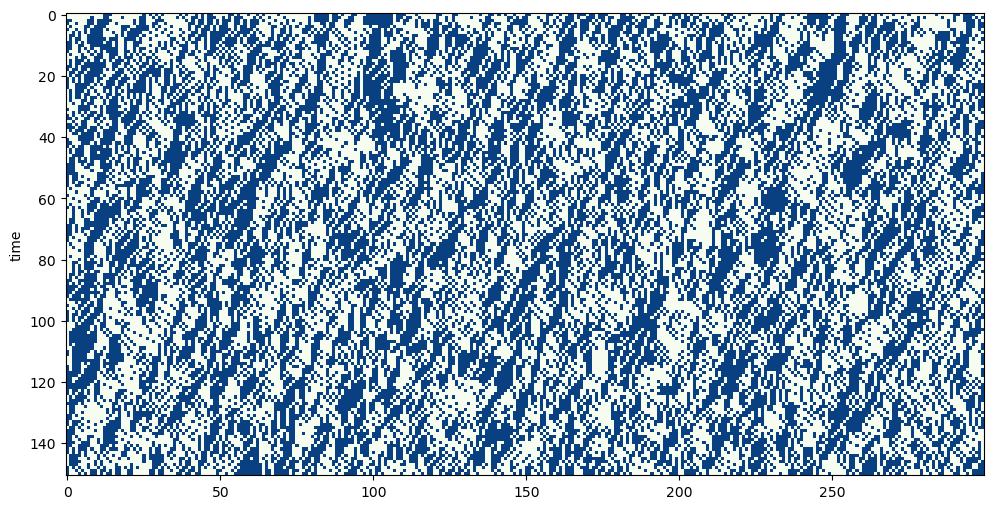

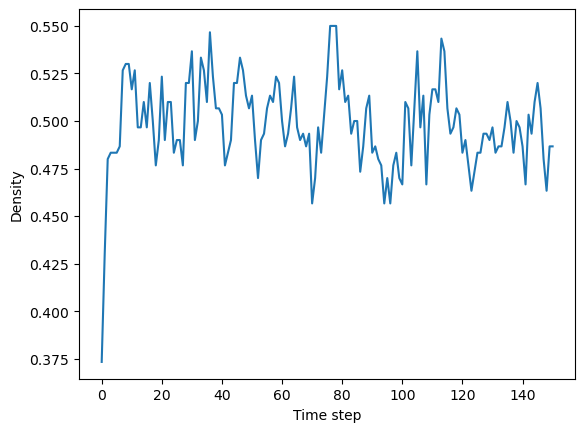

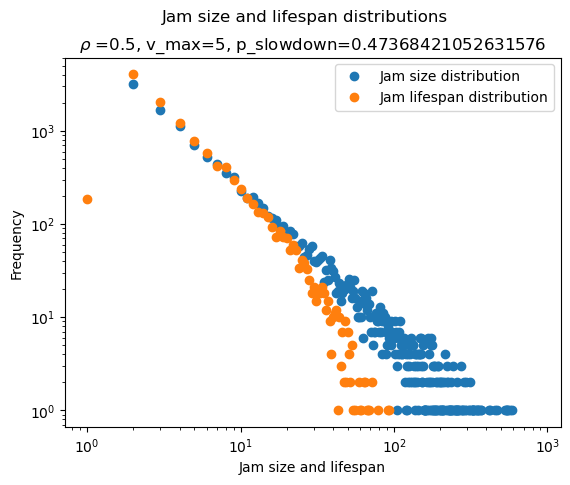

Calculating best minimal value for power law fit
Data prefers power_law over exponential (p-value: 0.0000)
1.6907868951716671
Calculating best minimal value for power law fit
Data prefers power_law over exponential (p-value: 0.0000)
1.6907868951716671


In [97]:
p = 0.2 #0.13793103448275862
L = 300
T = int(L/2)
n = 10

# NaSch parameters
p_slowdown = 0.47368421052631576
v_max = 5

# Dynamic parameters
neighbourhood_size = 30
entry_chance = 0.2
exit_chance = 0.2

current_state = initial_state_nasch(L=L, p=p, v_max=v_max)

evolution = nasch_step(current_state, v_max=v_max, p_slowdown=p_slowdown, 
                       dynamic_model=True, neighbourhood_size=neighbourhood_size, 
                       entry_chance=entry_chance, exit_chance=exit_chance)

lifespan_counter, jam_size_counter, evolutions = run_model_stochastic(p, L, T, n, v_max=v_max, p_slowdown = p_slowdown, 
                                                                      return_evolutions=True, dynamic_model=True, neighbourhood_size=neighbourhood_size,
                                                                      entry_chance=entry_chance, exit_chance=exit_chance)

# Visualize the evolution
evolution = evolutions[0]

location_evolution = [[x[0] for x in line] for line in evolution]
speed_evolution = [[x[1] for x in line] for line in evolution]

#flow = calculate_flow_nasch(evolution)
#print(f"Flow: {flow}")

# plot the car evolution
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the size as needed
cpl.plot(location_evolution, colormap='GnBu')

density_test = density_evolution_nasch(evolution)
plt.plot(density_test)
plt.ylabel('Density')
plt.xlabel('Time step')
plt.show()

plt.loglog(range(1, int(max(jam_size_counter.keys()))), [jam_size_counter[i] for i in range(1, int(max(jam_size_counter.keys())))], 'o')
plt.loglog(range(1, int(max(lifespan_counter.keys()))), [lifespan_counter[i] for i in range(1, int(max(lifespan_counter.keys())))], 'o')
plt.legend(['Jam size distribution', 'Jam lifespan distribution'])
plt.title('$\\rho$ =0.5, v_max=5, p_slowdown=0.47368421052631576')
plt.xlabel('Jam size and lifespan')
plt.ylabel('Frequency')
plt.suptitle('Jam size and lifespan distributions')
plt.show()

result, exponent = analyze_powerlaw_distribution(list(jam_size_counter.elements()))
print(result) #print result of power law test
print(exponent)
result_lifespan_test = analyze_powerlaw_distribution(list(lifespan_counter.elements()))
print(result) #print result of power law test
print(exponent)

Calculating best minimal value for power law fit
for initial density: 0.1
('Data prefers power_law over exponential (p-value: 0.0000)', 4.147168833470982)
Calculating best minimal value for power law fit
for initial density: 0.2
('Data prefers power_law over exponential (p-value: 0.0000)', 2.9743928422647503)
Calculating best minimal value for power law fit
for initial density: 0.30000000000000004
('Data prefers power_law over exponential (p-value: 0.1807)', 3.1265908546790433)
Calculating best minimal value for power law fit
for initial density: 0.4
('Data prefers power_law over exponential (p-value: 0.0137)', 2.5719675048086845)
Calculating best minimal value for power law fit
for initial density: 0.5
('Data prefers power_law over exponential (p-value: 0.0000)', 1.5075059256937162)
Calculating best minimal value for power law fit
for initial density: 0.6
('Data prefers exponential over power_law (p-value: 0.2571)', 5.681544667551412)
Calculating best minimal value for power law fit
f

ValueError: x and y must have same first dimension, but have shapes (9,) and (1,)

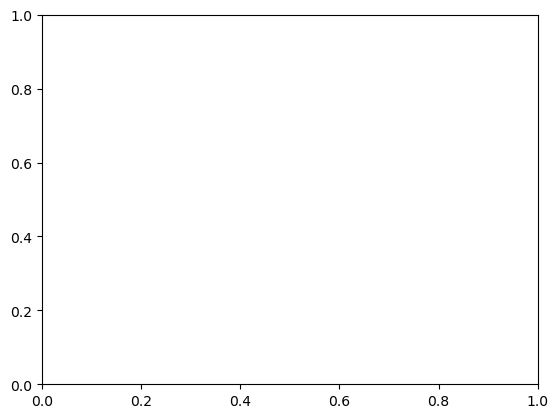

In [154]:
p_value = np.linspace(0.1, 0.9, 9)

for p in p_value: 
    current_state = initial_state_nasch(L=L, p=p, v_max=v_max)

    evolution = nasch_step(current_state, v_max=v_max, p_slowdown=p_slowdown, 
                        dynamic_model=False, neighbourhood_size=neighbourhood_size, 
                        entry_chance=entry_chance, exit_chance=exit_chance)

    lifespan_counter, jam_size_counter, evolutions = run_model_stochastic(p, L, T, n, v_max=v_max, p_slowdown = p_slowdown, 
                                                                        return_evolutions=True, dynamic_model=False, neighbourhood_size=neighbourhood_size,
                                                                        entry_chance=entry_chance, exit_chance=exit_chance)

    result_jam_test = analyze_powerlaw_distribution(list(jam_size_counter.elements()))
    print ("for initial density:", p) 
    print(result_jam_test) #print result of power law test



Calculating best minimal value for power law fit
Data prefers power_law over exponential (p-value: 0.0000)
1.5174906970549085
Calculating best minimal value for power law fit
('Data prefers power_law over exponential (p-value: 0.0000)', 1.9655531888953481)
Counter({2: 5016, 3: 2621, 4: 1725, 5: 1207, 6: 919, 7: 706, 8: 596, 9: 460, 10: 402, 11: 396, 151: 378, 12: 326, 13: 283, 14: 265, 15: 225, 17: 212, 16: 165, 18: 163, 19: 157, 20: 149, 21: 144, 23: 133, 22: 129, 28: 116, 24: 108, 26: 98, 25: 93, 30: 90, 29: 89, 27: 86, 32: 72, 34: 66, 33: 65, 31: 62, 35: 60, 37: 59, 36: 52, 51: 48, 39: 46, 40: 46, 38: 45, 41: 45, 46: 44, 42: 43, 47: 42, 44: 42, 48: 42, 45: 41, 49: 39, 43: 38, 53: 37, 50: 37, 52: 36, 54: 36, 72: 35, 58: 34, 55: 33, 77: 30, 67: 30, 57: 30, 61: 29, 60: 29, 68: 28, 62: 28, 73: 28, 76: 24, 78: 24, 64: 24, 56: 24, 63: 24, 100: 23, 74: 23, 70: 23, 87: 21, 66: 21, 59: 20, 80: 19, 101: 18, 111: 18, 81: 18, 97: 18, 79: 18, 75: 17, 84: 17, 88: 17, 65: 16, 69: 16, 95: 15, 83: 1

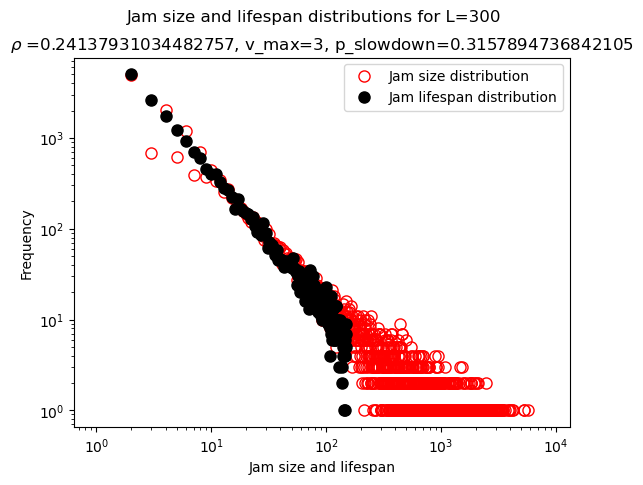

In [150]:
import sys
sys.setrecursionlimit(10000)

#Critical densities for p_slowdown and vmax
#0.3157894736842105,3,"[0.20689655172413793, 0.20689655172413793, 0.27586206896551724, 0.27586206896551724, 0.24137931034482757]

p = 0.8 #0.24137931034482757
L = 300
T = int(L/2)
n = 50

# NaSch parameters
p_slowdown = 0.3157894736842105
v_max = 3

# Dynamic parameters
neighbourhood_size = 3
entry_chance = 0.01
exit_chance = 0.01

current_state = initial_state_nasch(L=L, p=p, v_max=v_max)

evolution = nasch_step(current_state, v_max=v_max, p_slowdown=p_slowdown, 
                       dynamic_model=False, neighbourhood_size=neighbourhood_size, 
                       entry_chance=entry_chance, exit_chance=exit_chance)

lifespan_counter, jam_size_counter, evolutions = run_model_stochastic(p, L, T, n, v_max=v_max, p_slowdown = p_slowdown, 
                                                                      return_evolutions=True, dynamic_model=False, neighbourhood_size=neighbourhood_size,
                                                                      entry_chance=entry_chance, exit_chance=exit_chance)


def power(x,b):
    return x**(-b)

result, exponent = analyze_powerlaw_distribution(list(jam_size_counter.elements()))
print(result) #print result of power law test
print(exponent)
esult_lifespan_test = analyze_powerlaw_distribution(list(lifespan_counter.elements()))
print(result_lifespan_test) #print result of power law test
print(lifespan_counter)   

plt.loglog(range(1, int(max(jam_size_counter.keys()))), [jam_size_counter[i] for i in range(1, int(max(jam_size_counter.keys())))], 'o', markerfacecolor='none', markeredgecolor='red', markersize=8)
plt.loglog(range(1, int(max(lifespan_counter.keys()))), [lifespan_counter[i] for i in range(1, int(max(lifespan_counter.keys())))], 'o', color='black', markersize=8)
#line to plot the critical exponent line in the plot 
#plt.loglog(range(1, int(max(jam_size_counter.keys()))), power(range(1, int(max(jam_size_counter.keys()))), exponent), '--')
plt.legend(['Jam size distribution', 'Jam lifespan distribution'])
plt.title('$\\rho$ =0.24137931034482757, v_max=3, p_slowdown=0.3157894736842105')
plt.xlabel('Jam size and lifespan')
plt.ylabel('Frequency')
plt.suptitle('Jam size and lifespan distributions for L=300')
plt.show()



Calculating best minimal value for power law fit
Data prefers power_law over exponential (p-value: 0.0448)
3.373879888903863
Calculating best minimal value for power law fit
('Data prefers power_law over exponential (p-value: 0.0000)', 1.9655531888953481)
Counter({2: 743, 3: 303, 4: 138, 5: 65, 6: 42, 7: 24, 8: 14, 9: 13, 10: 5, 13: 2, 12: 2, 15: 1, 16: 1, 11: 1})


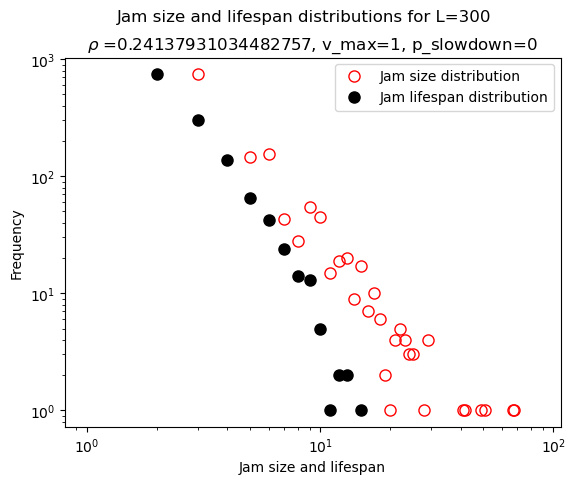

In [152]:
import sys
sys.setrecursionlimit(10000)

p = 0.24137931034482757
L = 300
T = int(L/2)
n = 100

# NaSch parameters
p_slowdown = 0
v_max = 1

# Dynamic parameters
neighbourhood_size = 3
entry_chance = 0.01
exit_chance = 0.01

current_state = initial_state_nasch(L=L, p=p, v_max=v_max)

evolution = nasch_step(current_state, v_max=v_max, p_slowdown=p_slowdown, 
                       dynamic_model=False, neighbourhood_size=neighbourhood_size, 
                       entry_chance=entry_chance, exit_chance=exit_chance)

lifespan_counter, jam_size_counter, evolutions = run_model_stochastic(p, L, T, n, v_max=v_max, p_slowdown = p_slowdown, 
                                                                      return_evolutions=True, dynamic_model=False, neighbourhood_size=neighbourhood_size,
                                                                      entry_chance=entry_chance, exit_chance=exit_chance)


def power(x,b):
    return x**(-b)

result, exponent = analyze_powerlaw_distribution(list(jam_size_counter.elements()))
print(result) #print result of power law test
print(exponent)
esult_lifespan_test = analyze_powerlaw_distribution(list(lifespan_counter.elements()))
print(result_lifespan_test) #print result of power law test
print(lifespan_counter)   

plt.loglog(range(1, int(max(jam_size_counter.keys()))), [jam_size_counter[i] for i in range(1, int(max(jam_size_counter.keys())))], 'o', markerfacecolor='none', markeredgecolor='red', markersize=8)
plt.loglog(range(1, int(max(lifespan_counter.keys()))), [lifespan_counter[i] for i in range(1, int(max(lifespan_counter.keys())))], 'o', color='black', markersize=8)
#line to plot the critical exponent line in the plot 
#plt.loglog(range(1, int(max(jam_size_counter.keys()))), power(range(1, int(max(jam_size_counter.keys()))), exponent), '--')
plt.legend(['Jam size distribution', 'Jam lifespan distribution'])
plt.title('$\\rho$ =0.24137931034482757, v_max=1, p_slowdown=0')
plt.xlabel('Jam size and lifespan')
plt.ylabel('Frequency')
plt.suptitle('Jam size and lifespan distributions for L=300')
plt.show()

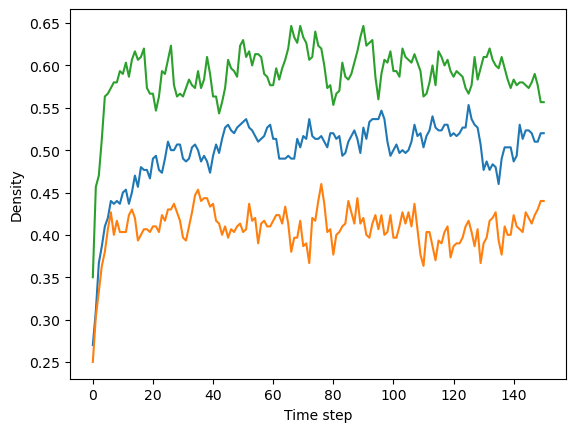

In [234]:
p = 0.2 #0.13793103448275862
L = 300
T = int(L/2)
n = 10

# NaSch parameters
p_slowdown = 0.4
v_max = 3

# Dynamic parameters
neighbourhood_size = 50
entry_chance = 0.1
exit_chance = 0.1

current_state = initial_state_nasch(L=L, p=p, v_max=v_max)

evolution = nasch_step(current_state, v_max=v_max, p_slowdown=p_slowdown, 
                       dynamic_model=True, neighbourhood_size=neighbourhood_size, 
                       entry_chance=entry_chance, exit_chance=exit_chance)

lifespan_counter, jam_size_counter, evolutions = run_model_stochastic(p, L, T, n, v_max=v_max, p_slowdown = p_slowdown, 
                                                                      return_evolutions=True, dynamic_model=True, neighbourhood_size=neighbourhood_size,
                                                                      entry_chance=entry_chance, exit_chance=exit_chance)

# Visualize the evolution
evolution = evolutions[0]

density_test_01_01 = density_evolution_nasch(evolution)

entry_chance = 0.2
exit_chance = 0.1

current_state = initial_state_nasch(L=L, p=p, v_max=v_max)

evolution = nasch_step(current_state, v_max=v_max, p_slowdown=p_slowdown, 
                       dynamic_model=True, neighbourhood_size=neighbourhood_size, 
                       entry_chance=entry_chance, exit_chance=exit_chance)

lifespan_counter, jam_size_counter, evolutions = run_model_stochastic(p, L, T, n, v_max=v_max, p_slowdown = p_slowdown, 
                                                                      return_evolutions=True, dynamic_model=True, neighbourhood_size=neighbourhood_size,
                                                                      entry_chance=entry_chance, exit_chance=exit_chance)

# Visualize the evolution
evolution = evolutions[0]
density_test_02_01 = density_evolution_nasch(evolution)

entry_chance = 0.1
exit_chance = 0.2

current_state = initial_state_nasch(L=L, p=p, v_max=v_max)

evolution = nasch_step(current_state, v_max=v_max, p_slowdown=p_slowdown, 
                       dynamic_model=True, neighbourhood_size=neighbourhood_size, 
                       entry_chance=entry_chance, exit_chance=exit_chance)

lifespan_counter, jam_size_counter, evolutions = run_model_stochastic(p, L, T, n, v_max=v_max, p_slowdown = p_slowdown, 
                                                                      return_evolutions=True, dynamic_model=True, neighbourhood_size=neighbourhood_size,
                                                                      entry_chance=entry_chance, exit_chance=exit_chance)

# Visualize the evolution
evolution = evolutions[0]
density_test_01_02 = density_evolution_nasch(evolution)

plt.plot(density_test_01_01)
plt.plot (density_test_01_02)
plt.plot(density_test_02_01)
plt.ylabel('Density')
plt.xlabel('Time step')
plt.show()



Critical density: 0.24489795918367346


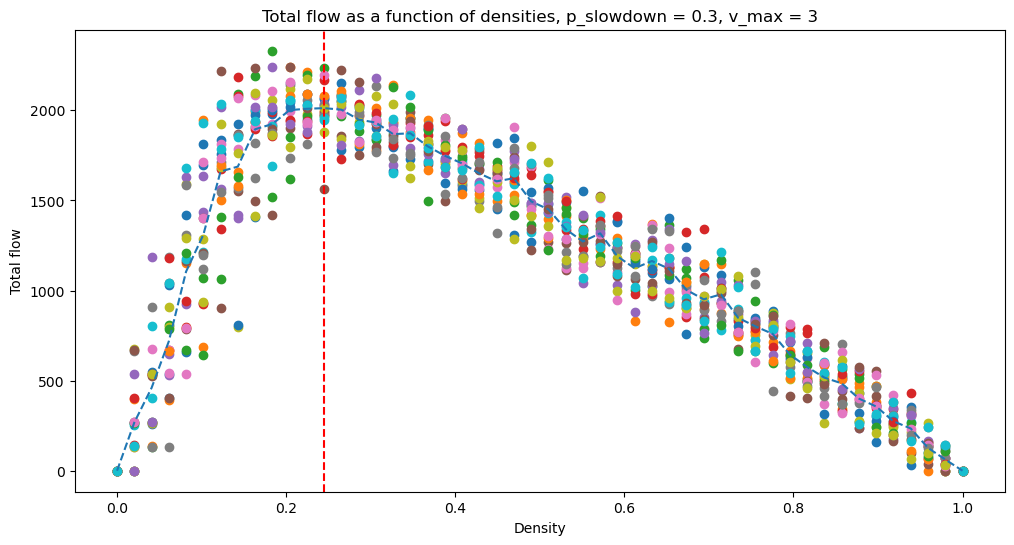

In [44]:
p = np.linspace(0.0, 1, 50)
L = 100
T = int(L / 2)
n = 20
p_slowdown = 0.3
v_max = 3

total_flows_per_density = dict()
average_flows_per_density = dict()

for density in p:
    lifespan_counter, jam_size_counter, evolutions = run_model_stochastic(density, L, T, n, v_max=v_max, p_slowdown = p_slowdown, 
                                                                      return_evolutions=True, dynamic_model=False, neighbourhood_size=neighbourhood_size,
                                                                      entry_chance=entry_chance, exit_chance=exit_chance)
    

    total_flows = [calculate_flow_nasch(evolution) for evolution in evolutions]
    average_flows = [flow / float(T) for flow in total_flows]
    
    total_flows_per_density[density] = total_flows
    average_flows_per_density[density] = average_flows

# Find critical point: the density for which the total flow average is maximum
mean_total_flow_per_density = {density: np.mean(flows) for density, flows in total_flows_per_density.items()}
critical_density = max(mean_total_flow_per_density, key=mean_total_flow_per_density.get)
print(f"Critical density: {critical_density}")

# plot total flow as a function of densities
plt.figure(figsize=(12,6))
plt.title(f'Total flow as a function of densities, p_slowdown = {p_slowdown}, v_max = {v_max}')
plt.plot(total_flows_per_density.keys(), total_flows_per_density.values(), 'o')
plt.plot(total_flows_per_density.keys(), [np.mean(flows) for flows in total_flows_per_density.values()], '--', label= "Critical density")

# Add a vertical line at the critical density
plt.axvline(x=critical_density, color='red', linestyle='--')

plt.xlabel('Density')
plt.ylabel('Total flow')
plt.show()

# Analyze powerlaw exponent of the NaSch traffic flow